In [1]:
import torch
import numpy as np
from torchtext.legacy import data
from torchtext.legacy import datasets

In [2]:
TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', include_lengths = True)
LABEL = data.LabelField()

fields = [('text', TEXT), ('label', LABEL)]
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'sentiment_3_new_tweet_validtestexchanged',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields
)

In [3]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 5147
Number of validation examples: 500
Number of testing examples: 500


In [30]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors = "glove.twitter.27B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [5]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 12695
Unique tokens in LABEL vocabulary: 3


In [32]:
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

['<unk>', '<pad>', 'the', 'to', 'of', 'coronavirus', ',', 'in', 'a', 'and']
defaultdict(None, {'3': 0, '4': 1, '2': 2})


In [7]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x : len(x.text),
    sort_within_batch = True,
    device = device)

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):

        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #concate the final forward (hidden[-2, :, :]) and backward (hidden[-1, :, :]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1))
        
        #hidden = [batch size, hid dim * num directions]
        
        return self.fc(hidden)

In [9]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 200
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [29]:
PAD_IDX

1

In [10]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.9859, -0.2253,  0.1287,  ..., -0.3901,  1.4014,  0.6982],
        [-0.7584, -0.6723, -0.0453,  ...,  2.3447,  0.4374,  1.0083],
        [ 0.0952,  0.3702,  0.5429,  ..., -0.5108,  0.4688,  0.3488],
        ...,
        [ 1.6566,  0.2806,  0.0337,  ...,  0.8610, -0.5657, -1.3537],
        [-0.4114,  0.2590, -0.3857,  ..., -0.4929,  1.5722,  0.7735],
        [ 0.3067,  0.6251, -0.7928,  ..., -0.2143, -2.3515,  0.3265]])

In [11]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [12]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [13]:
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [14]:
def compute_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    class_preds = torch.argmax(torch.softmax(preds, 1), dim=1)
    correct = (class_preds == (y)).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [15]:
from torchmetrics.functional import accuracy, precision, recall, f1

def compute_metrics(preds, y):
    """
    Returns precision, recall, F1-score of per batch
    """
    class_preds = torch.argmax(torch.softmax(preds, 1), dim=1)
    return (accuracy(class_preds, y), 
            precision(class_preds, y, num_classes=3, average='macro'), 
            recall(class_preds, y, num_classes=3, average='macro'), 
            f1(class_preds, y, num_classes=3, average='macro'))

In [16]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(iterator)
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, prec, recall, f1 = compute_metrics(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_f1 += f1.item()
        
    return epoch_loss/batches, epoch_acc/batches, epoch_prec/batches, epoch_recall/batches, epoch_f1/batches

In [17]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(iterator)
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc, prec, recall, f1 = compute_metrics(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_f1 += f1.item()
        
    return epoch_loss/batches, epoch_acc/batches, epoch_prec/batches, epoch_recall/batches, epoch_f1/batches

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
N_EPOCHS = 15

best_valid_loss = float('inf')
train_loss = np.zeros(N_EPOCHS)
train_acc = np.zeros(N_EPOCHS)
train_prec = np.zeros(N_EPOCHS)
train_recall = np.zeros(N_EPOCHS)
train_f1 = np.zeros(N_EPOCHS)
valid_loss = np.zeros(N_EPOCHS)
valid_acc = np.zeros(N_EPOCHS)
valid_prec = np.zeros(N_EPOCHS)
valid_recall = np.zeros(N_EPOCHS)
valid_f1 = np.zeros(N_EPOCHS)


for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss[i], train_acc[i], train_prec[i], train_recall[i], train_f1[i] = train(model, train_iterator, optimizer, criterion)
    valid_loss[i], valid_acc[i], valid_prec[i], valid_recall[i], valid_f1[i] = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}% | Train Prec: {train_prec[i]*100:.2f}% | Train Recall: {train_recall[i]*100:.2f}% | Train F1: {train_f1[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. Acc: {valid_acc[i]*100:.2f}% |  Val. Prec: {valid_prec[i]*100:.2f}% |  Val. Recall: {valid_recall[i]*100:.2f}% | Val.  F1: {valid_f1[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.912 | Train Acc: 59.13% | Train Prec: 34.75% | Train Recall: 36.99% | Train F1: 30.21%
	 Val. Loss: 0.820 |  Val. Acc: 67.48% |  Val. Prec: 45.62% |  Val. Recall: 45.15% | Val.  F1: 42.97%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.738 | Train Acc: 67.27% | Train Prec: 64.21% | Train Recall: 51.13% | Train F1: 51.74%
	 Val. Loss: 0.707 |  Val. Acc: 72.83% |  Val. Prec: 83.26% |  Val. Recall: 54.61% | Val.  F1: 58.24%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.642 | Train Acc: 72.50% | Train Prec: 70.15% | Train Recall: 61.48% | Train F1: 63.77%
	 Val. Loss: 0.695 |  Val. Acc: 71.97% |  Val. Prec: 73.99% |  Val. Recall: 58.31% | Val.  F1: 61.44%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.585 | Train Acc: 74.87% | Train Prec: 72.56% | Train Recall: 65.88% | Train F1: 67.65%
	 Val. Loss: 0.659 |  Val. Acc: 74.37% |  Val. Prec: 79.44% |  Val. Recall: 58.40% | Val.  F1: 62.11%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.526 | Train Acc: 78

In [27]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.497 | Test Acc: 81.96% | Test Prec: 85.07% | Test Recall: 72.19% | Test F1: 76.09%


In [21]:
import spacy
import numpy as np
nlp = spacy.load('en_core_web_sm')

def predict_singleSentence(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor)).cpu().detach().numpy()
    return np.argmax(prediction)

def predict_sentiment(model, sentences):
    pred_res = []
    for i, sentence in sentences.items():
        pred_res.append(predict_singleSentence(model, sentence))
    return pred_res

In [22]:
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def prec_rec_curve(model, X, Y_true, titile=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    n_classes = 3
    y_test = label_binarize(Y_true, classes=[2, 3, 4])
    predict_res = predict_sentiment(model, X)
    y_score = label_binarize(predict_res, classes=[2, 0, 1])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    micro_auc = roc_auc_score(y_test, y_score, average='micro')
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    macro_auc = roc_auc_score(y_test, y_score, average='macro')

    print(roc_auc)
    print('micro auc:', micro_auc)
    print('macro auc:', macro_auc)
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('figures/LSTM_ROC.jpg')

{0: 0.7654761904761905, 1: 0.8090736155069778, 2: 0.812232358964811, 'micro': 0.8635, 'macro': 0.7955940549826597}
micro auc: 0.8635
macro auc: 0.7955940549826598


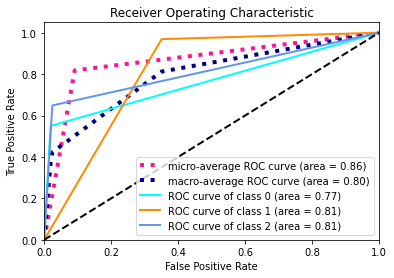

In [23]:
import pandas as pd
test_df = pd.read_csv("sentiment_3_new_tweet_validtestexchanged/test.csv", header=None)

prec_rec_curve(model, test_df[0], test_df[1])

### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

y_test_pred = predict_sentiment(model,  test_df[0])
y_test_pred = np.array([int(LABEL.vocab.itos[label]) for label in y_test_pred])
y_test_true = test_df[1].apply(int).values
cm = confusion_matrix(y_test_pred, y_test_true, normalize='true')
cm

array([[0.84615385, 0.11538462, 0.03846154],
       [0.08474576, 0.79096045, 0.12429379],
       [0.06382979, 0.03191489, 0.90425532]])

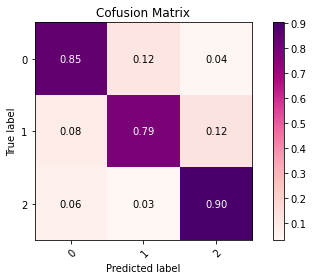

In [25]:
normalize = True
cmap = 'RdPu'
classes = [0, 1, 2]
title = 'Cofusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
        fig.tight_layout()
plt.savefig('figures/LSTM_CM.jpg')

### Metrics Cruves

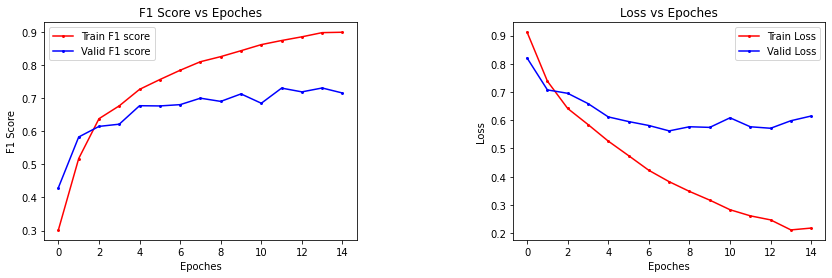

In [26]:
totEpoch = N_EPOCHS
x = range(0, totEpoch)
plt.figure(figsize=(14,4))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[:,0])
# plt.plot(x, F1_list_train, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, train_f1, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, valid_f1, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid F1 score')
plt.legend()
plt.title('F1 Score vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('F1 Score')
plt.subplot(grid[:,1])
plt.plot(x, train_loss, color="red", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train Loss')
plt.plot(x, valid_loss, color="blue", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid Loss')
plt.legend()
plt.title('Loss vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.savefig('figures/LSTM Loss_F1.jpg')